## 10-5. 프로젝트: 더 멋진 번역기 만들기

In [1]:
#!cp -r /aiffel/data  /aiffel/aiffel/transformer

#### 라이브러리 버전을 확인해 봅니다.
사용할 라이브러리 버전을 둘러봅시다.

In [1]:
import tensorflow
import numpy
import matplotlib

print(tensorflow.__version__)
print(numpy.__version__)
print(matplotlib.__version__)

2.6.0
1.21.4
3.4.3


In [2]:
import os,sys,time,copy
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io
import re
import random

In [3]:
# plot 시 한글처리
import matplotlib as mpl
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)


'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

#### Step 1. 데이터 다운로드 (클라우드 유저용)
아래 링크에서 korean-english-park.train.tar.gz 를 사용할 예정입니다. 다운로드할 필요는 없습니다.

* [jungyeul/korean-parallel-corpora](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)

☁️클라우드 환경에서는 위 데이터를 미리 준비해 놓았으니 연결만 시켜줍시다. 우측 하단의 Cloud shell을 열어주세요.
아래와 같이 공유 디렉토리에 저장된 데이터를 가리키는 심볼릭 링크를 생성해 주시면 됩니다.
```
$ ln -s ~/data ~/aiffel/transformer/data
```

#### Step 2. 데이터 정제 및 토큰화
1. set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거하도록 합니다. 데이터의 병렬 쌍이 흐트러지지 않게 주의하세요! 중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.

In [4]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    # [[YOUR CODE]]
    print(len(kor), len(eng))    
    cleaned_corpus = list(set(zip(kor,eng)))
    # 문장별로 튜플을 풀어서 str 로 전환: 한개의 문장내 한글 vs 영어는 공백4칸으로 구분, 문장별 구분은 '\n'으로 구분
    cleaned_corpus = [line[0] + ' '*4 + line[1] +'\n' for line in cleaned_corpus]
    print("cleaned_corpus",cleaned_corpus[:2], len(cleaned_corpus))
   
    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)

#결측치체크 및 제거
# 결측치 체크위해 DataFrame만들기: 
df = pd.DataFrame({'cleaned_corpus': cleaned_corpus}) 
# 결측치제거 : 1개라도 있으면, 해당행 전체 제거
print("결측치 개수",df.isnull().sum())
if df.isnull().any().any():
    df.dropna(how='any',inplace=True)
    print("결측치제거후 결측치 여부",df.isnull().any().any())     
# 원래의 cleaned_corpus 형태로 변경
cleaned_corpus = [x[0] for x in df.values.tolist()]
print("cleaned_corpus",cleaned_corpus[:2], len(cleaned_corpus))

# 저장
with open(os.getenv('HOME')+'/aiffel/transformer/cleaned_corpus/cleaned_corpus', 'w') as f:  
        for line in cleaned_corpus:
            #line = line[0]+' '*4 + line[1] + '\n'
            f.write(line)
            
# 저장여부 확인
with open(os.getenv('HOME')+'/aiffel/transformer/cleaned_corpus'+ '/cleaned_corpus', "r") as f:    
    cleaned_corpus_check = f.read().splitlines()    # \n 떼어 놓고, line별 구분됨 
    
print("저장된 cleaned_corpus 로드후 확인: ", cleaned_corpus_check[:2])
print("중복 맟 결측치 제거후 문장개수: ", len(cleaned_corpus))   


94123 94123
cleaned_corpus ['두바이 해변 성관계 英 커플 보석으로 석방    `Sex on beach` couple free on bail in Dubai\n', '우리는 희생자와 그 유가족들 그리고 미국민 들에게 깊은 애도를 표한다.” 라고 말했다.    "We convey deep condolences to victims, families and the American people.\n'] 78968
결측치 개수 cleaned_corpus    0
dtype: int64
cleaned_corpus ['두바이 해변 성관계 英 커플 보석으로 석방    `Sex on beach` couple free on bail in Dubai\n', '우리는 희생자와 그 유가족들 그리고 미국민 들에게 깊은 애도를 표한다.” 라고 말했다.    "We convey deep condolences to victims, families and the American people.\n'] 78968
저장된 cleaned_corpus 로드후 확인:  ['두바이 해변 성관계 英 커플 보석으로 석방    `Sex on beach` couple free on bail in Dubai', '우리는 희생자와 그 유가족들 그리고 미국민 들에게 깊은 애도를 표한다.” 라고 말했다.    "We convey deep condolences to victims, families and the American people.']
중복 맟 결측치 제거후 문장개수:  78968


2. 정제 함수를 아래 조건을 만족하게 정의하세요.
>
> * 모든 입력을 소문자로 변환합니다.
> * 알파벳, 문장부호, 한글만 남기고 모두 제거합니다.
> * 문장부호 양옆에 공백을 추가합니다.
> * 문장 앞뒤의 불필요한 공백을 제거합니다.
>

In [5]:
def preprocess_sentence(sentence, mecab_eng = False):
    
    # [[YOUR CODE]]
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^0-9ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    
    if mecab_eng == True:
        sentence =  '<BOS> ' + sentence + ' <EOS>'
        
    return sentence


문장 알파벳길이별 분포체크:  분포도 상 특이한 이상치 없슴

kor_max 377


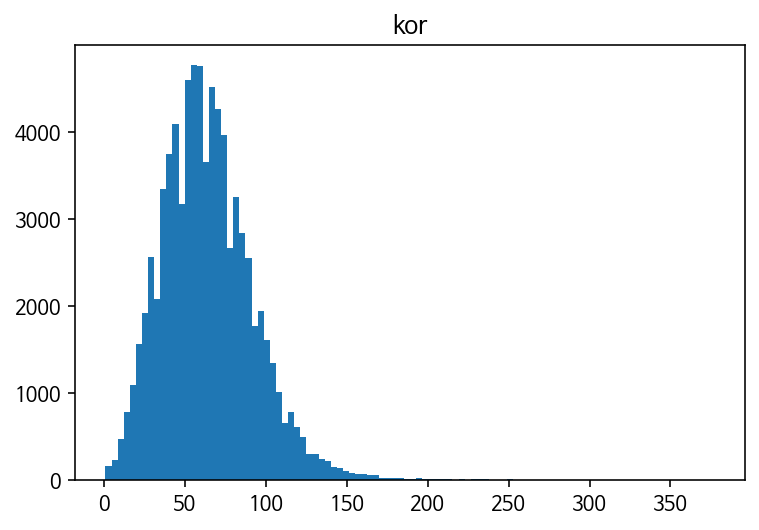

eng_max 606


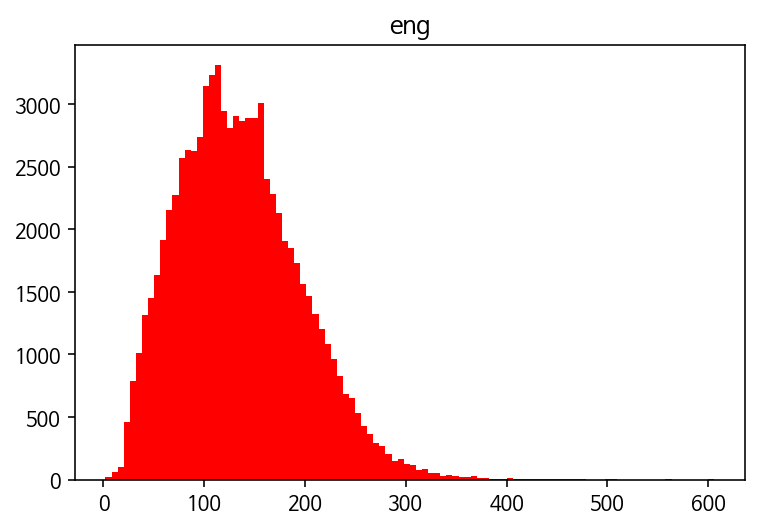

kor ['두바이 해변 성관계 英 커플 보석으로 석방', '우리는 희생자와 그 유가족들 그리고 미국민 들에게 깊은 애도를 표한다.” 라고 말했다.', '이라크 정부는 민병대의 철수를 반겼으며 누리 알-말리키 이라크 총리는 “알-사드르가 옳은 결정을 내렸다고 이 지역의 평화와 안정을 위해 함께 노력했으면 한다”고 말했다.']
eng ['`Sex on beach` couple free on bail in Dubai\n', '"We convey deep condolences to victims, families and the American people.\n', "Al-Sadr's political movement holds 30 seats in Iraq's 275-member parliament and was once a partner in al-Maliki's ruling coalition. The party quit the government in 2007 after al-Maliki refused to demand a deadline for the withdrawal of U.S. troops.\n"]


In [6]:
raw_kor_corpus = []
raw_eng_corpus = []

for pair in cleaned_corpus:
    raw_kor, raw_eng = pair.split(" "*4)  
    raw_kor_corpus.append(raw_kor)
    raw_eng_corpus.append(raw_eng)  # 아래 코드에서 set_encode_extra_options("bos:eos")으로 자동으로 '<BOS>', '<EOS>' 붙음

## 문장길이별 분포 
korlen = [len(x) for x in raw_kor_corpus]
kor_max= np.max(korlen)
print("kor_max", kor_max)
plt.hist(korlen, bins= 100)
plt.title("kor")
plt.show()

englen = [len(x) for x in raw_eng_corpus]
eng_max= np.max(englen)
print("eng_max", eng_max)
plt.hist(englen, bins= 100, color='red')
plt.title("eng")
plt.show()

## sample
print("kor",raw_kor_corpus[:3])
print("eng",raw_eng_corpus[:3])

3. 한글 말뭉치 kor_corpus 와 영문 말뭉치 eng_corpus 를 각각 분리한 후, 정제하여 토큰화를 진행합니다! 토큰화에는 Sentencepiece를 활용하세요. 첨부된 공식 사이트를 참고해 아래 조건을 만족하는 generate_tokenizer() 함수를 정의합니다. 최종적으로 ko_tokenizer 과 en_tokenizer 를 얻으세요. en_tokenizer에는 set_encode_extra_options("bos:eos") 함수를 실행해 타겟 입력이 문장의 시작 토큰과 끝 토큰을 포함할 수 있게 합니다.
* [google/sentencepiece](https://github.com/google/sentencepiece)

단어 사전을 매개변수로 받아 원하는 크기의 사전을 정의할 수 있게 합니다. (기본: 20,000)   
학습 후 저장된 **model** 파일을 **SentencePieceProcessor() 클래스에 Load()** 한 후 반환합니다.   
특수 토큰의 인덱스를 아래와 동일하게 지정합니다.      
**PAD : 0 / BOS : 1 / EOS : 2 / UNK : 3**

**sentencepiece용**

In [8]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus_path, vocab_size, lang="ko", pad_id=0, bos_id=1, eos_id=2, unk_id=3,
                   pad_piece="<PAD>", bos_piece="<BOS>", eos_piece="<EOS>", unk_piece="<UNK>" ):
    
    # [[YOUR CODE]]
    #temp_file = os.getenv('HOME')+'/aiffel/transformer/cleaned_corpus/cleaned_corpus'
    # SentencePiece 학습
    if lang == "ko":
        import sentencepiece as spm 
        # --pad_piece={} --bos_piece={} --eos_piece={} --unk_piece={}
        spm.SentencePieceTrainer.Train(
                '--input={} --model_prefix=korean_spm --vocab_size={} --pad_id={} --unk_id={} --pad_piece={} --unk_piece={}'.format(
            corpus_path, vocab_size, pad_id, unk_id, pad_piece, unk_piece))
        #!ls -l korean_spm* 
        # SentencePiece tokenizer 객체생성
        tokenizer = spm.SentencePieceProcessor()
        tokenizer.Load('korean_spm.model')
        
        # 단어사전생성
        #vocab_word, word_index, index_word = word_index_and_index_word(tokenizer, corpus, kor=True) 
    else: 
        import sentencepiece as spm1
        spm1.SentencePieceTrainer.Train(
            '--input={} --model_prefix=english_spm --vocab_size={} --pad_id={},--bos_id={} --eos_id={} --unk_id={} --pad_piece={} --bos_piece={} --eos_piece={} --unk_piece={}'.format(
            corpus_path, vocab_size, pad_id, bos_id, eos_id, unk_id, pad_piece, bos_piece, eos_piece, unk_piece))
        !ls -l english_spm*
        # SentencePiece tokenizer 객체생성
        tokenizer = spm1.SentencePieceProcessor()
        tokenizer.Load('english_spm.model')
        
        # 단어사전생성   
        #vocab_word, word_index, index_word = word_index_and_index_word(tokenizer, corpus, kor=False)   
    
    return tokenizer   #, vocab_word, word_index, index_word
    

SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 25000

eng_corpus = []
kor_corpus = []

for pair in cleaned_corpus:
    k, e = pair.split(" "*4)  
    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))  # 아래 코드에서 set_encode_extra_options("bos:eos")으로 자동으로 '<BOS>', '<EOS>' 붙음

# 분리된 데이터 저장
kor_corpus_path = os.getenv('HOME')+'/aiffel/transformer/cleaned_corpus/kor_corpus'
eng_corpus_path = os.getenv('HOME')+'/aiffel/transformer/cleaned_corpus/eng_corpus'

with open(kor_corpus_path, 'w') as f:  
    for line in kor_corpus:
        line = line + '\n'
        f.write(line)
with open(eng_corpus_path, 'w') as f:  
    for line in eng_corpus:
        line = line + '\n'
        f.write(line)
        
kor_tokenizer  = generate_tokenizer(kor_corpus_path, SRC_VOCAB_SIZE, "ko")
eng_tokenizer = generate_tokenizer(eng_corpus_path, TGT_VOCAB_SIZE, "en")

# 별도로 '<BOS>', '<EOS>' 코딩않해도 영어문장 앞뒤로 붙게해주는 옵션: sentencepiece 경우만 해당
eng_tokenizer.set_encode_extra_options("bos:eos")


sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/transformer/cleaned_corpus/kor_corpus --model_prefix=korean_spm --vocab_size=25000 --pad_id=0 --unk_id=3 --pad_piece=<PAD> --unk_piece=<UNK>
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/transformer/cleaned_corpus/kor_corpus
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 25000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limi

-rw-r--r-- 1 root root 650521 Mar 12 11:29 english_spm.model
-rw-r--r-- 1 root root 434854 Mar 12 11:29 english_spm.vocab


True

In [9]:
## 체크용 셀
# '<BOS>', '<EOS>' 자동으로 붙는지 테스트 : OK
tokens = eng_tokenizer.EncodeAsPieces(eng_corpus[0]) 
print("'<BOS>', '<EOS>' 자동으로 붙는지 테스트:", tokens)

# "한글, 영어 분리잘되었나 저장분 확인        
with open(kor_corpus_path, "r") as f: kor_check = f.read().splitlines()
print("kor_corpus 저장분 확인",len(kor_check), kor_check[:5])    
with open(eng_corpus_path, "r") as f: eng_check = f.read().splitlines() 
print("eng_corpus 저장분 확인", len(eng_check), eng_check[:5])   


'<BOS>', '<EOS>' 자동으로 붙는지 테스트: ['<BOS>', '▁sex', '▁on', '▁beach', '▁couple', '▁free', '▁on', '▁bail', '▁in', '▁dubai', '<EOS>']
kor_corpus 저장분 확인 78968 ['두바이 해변 성관계 커플 보석으로 석방', '우리는 희생자와 그 유가족들 그리고 미국민 들에게 깊은 애도를 표한다 . 라고 말했다 .', '이라크 정부는 민병대의 철수를 반겼으며 누리 알 말리키 이라크 총리는 알 사드르가 옳은 결정을 내렸다고 이 지역의 평화와 안정을 위해 함께 노력했으면 한다 고 말했다 .', '힐러리 클린턴 상원의원은 17일 현지시간 자신이 이라크전쟁을 끝낼 수 있는 리더십을 갖춘 유일한 대선후보라고 밝혔다 .', '그들은 관공서 일자리 고용에서부터 주지사의 친구나 기부자들의 행동에 이르기까지 일리노이 주지사의 일거수일투족을 감시해 왔습니다 .']
eng_corpus 저장분 확인 78968 ['sex on beach couple free on bail in dubai', 'we convey deep condolences to victims , families and the american people .', 'al sadr s political movement holds 30 seats in iraq s 275 member parliament and was once a partner in al maliki s ruling coalition . the party quit the government in 2007 after al maliki refused to demand a deadline for the withdrawal of u . s . troops .', 'hillary clinton said monday she is the only candidate who would exercise the leadership needed to end the war in iraq 

In [10]:
# word_index, index_word 생성함수
def word_index_and_index_word(tokenizer, corpus, kor=False):
    
    corpus_token = []
    as_piece = []
    for sen in corpus:
        corpus_token.append(tokenizer.EncodeAsIds(sen))
        as_piece.append(tokenizer.EncodeAsPieces(sen))
        
    print(corpus[:3],corpus_token[:3],as_piece[:3])  
    print()
    
    if kor==True:  path = "./korean_spm.vocab"
    else:   path = "./english_spm.vocab"
        
    with open(path, 'r') as f:  vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]
        word_index.update({word:idx})
        index_word.update({idx:word})
  
    return  corpus_token, word_index, index_word


# 토큰화완료된 한글 코퍼스 및 한글 단어사전생성   
kor_corpus_token, kor_word_index, kor_index_word = word_index_and_index_word(kor_tokenizer, kor_corpus, kor= True)
# 토큰화완료된 영어 코퍼스 및 영어 단어사전생성   
eng_corpus_token, eng_word_index, eng_index_word = word_index_and_index_word(eng_tokenizer, eng_corpus)   

['두바이 해변 성관계 커플 보석으로 석방', '우리는 희생자와 그 유가족들 그리고 미국민 들에게 깊은 애도를 표한다 . 라고 말했다 .', '이라크 정부는 민병대의 철수를 반겼으며 누리 알 말리키 이라크 총리는 알 사드르가 옳은 결정을 내렸다고 이 지역의 평화와 안정을 위해 함께 노력했으면 한다 고 말했다 .'] [[3593, 3585, 3181, 3427, 12701, 584], [111, 6, 1629, 28, 22, 12863, 187, 48, 1612, 8, 629, 2446, 9, 4552, 10, 8, 11759, 4, 180, 31, 4], [79, 70, 6, 2227, 7, 995, 10, 18177, 42, 3607, 163, 2405, 79, 102, 6, 163, 2915, 11, 8, 24871, 9, 456, 5, 1281, 15, 19, 164, 7, 583, 28, 1883, 5, 43, 178, 24432, 184, 138, 26, 31, 4]] [['▁두바이', '▁해변', '▁성관계', '▁커플', '▁보석으로', '▁석방'], ['▁우리', '는', '▁희생자', '와', '▁그', '▁유가족들', '▁그리고', '▁미국', '민', '▁', '들에게', '▁깊', '은', '▁애도', '를', '▁', '표한다', '▁.', '▁라고', '▁말했다', '▁.'], ['▁이라크', '▁정부', '는', '▁민병대', '의', '▁철수', '를', '▁반겼', '으며', '▁누리', '▁알', '▁말리키', '▁이라크', '▁총리', '는', '▁알', '▁사드르', '가', '▁', '옳', '은', '▁결정', '을', '▁내렸다', '고', '▁이', '▁지역', '의', '▁평화', '와', '▁안정', '을', '▁위해', '▁함께', '▁노력했으', '면', '▁한다', '▁고', '▁말했다', '▁.']]

['sex on beach couple free on bail in dubai', 'we convey de

In [11]:
## 토큰화 완료된 한글, 영어 코퍼스 문장 확인 kor_vocab_word
print("kor_corpus의 정수인덱스 token으로 전환확인", kor_corpus_token[:5])
print()
print("eng_corpus의 정수인덱스 token으로 전환확인", eng_corpus_token[:5])
print()

## 한글사전 샘플 확인
print("kor_index_word[0~20]",[(k,v) for (k,v) in kor_index_word.items() if k<=20])
print("kor_word_index[0~20]",[(k,v) for (k,v) in kor_word_index.items() if v <=20])  
print()

## 영어사전 샘플 확인
print("eng_index_word[0~20]",[(k,v) for (k,v) in eng_index_word.items() if k<=20])
print("eng_word_index[0~20]",[(k,v) for (k,v) in eng_word_index.items() if v <=20])   
print()

## 토큰화완료된 corpus 크기 및 단어사전크기확인
print("토큰화완료된 kor_corpus_token의 크기확인:", len(kor_corpus_token))
print("토큰화완료된 eng_corpus_token의 크기확인:", len(eng_corpus_token))
print("한글사전크기",kor_tokenizer.GetPieceSize())
print("영어사전크기",eng_tokenizer.GetPieceSize())

kor_corpus의 정수인덱스 token으로 전환확인 [[3593, 3585, 3181, 3427, 12701, 584], [111, 6, 1629, 28, 22, 12863, 187, 48, 1612, 8, 629, 2446, 9, 4552, 10, 8, 11759, 4, 180, 31, 4], [79, 70, 6, 2227, 7, 995, 10, 18177, 42, 3607, 163, 2405, 79, 102, 6, 163, 2915, 11, 8, 24871, 9, 456, 5, 1281, 15, 19, 164, 7, 583, 28, 1883, 5, 43, 178, 24432, 184, 138, 26, 31, 4], [548, 252, 447, 9, 375, 21, 54, 561, 79, 10898, 5, 2432, 2967, 27, 34, 9801, 5, 1798, 3061, 1386, 16, 987, 215, 30, 4], [22, 86, 18724, 1646, 1938, 17, 323, 570, 7, 1009, 65, 4693, 1552, 7, 5855, 6842, 128, 3588, 570, 7, 260, 193, 264, 21, 2210, 3301, 5, 1561, 73, 8404, 4]]

eng_corpus의 정수인덱스 token으로 전환확인 [[1, 787, 19, 1770, 731, 443, 19, 3402, 11, 2585, 2], [1, 61, 5681, 1160, 5795, 7, 8, 881, 6, 1360, 79, 12, 4, 177, 54, 5, 2], [1, 105, 2382, 16, 304, 1213, 665, 7, 318, 1710, 11, 122, 16, 128, 3, 585, 639, 755, 12, 25, 19, 194, 9, 2237, 11, 105, 2083, 186, 16, 712, 1021, 5, 4, 119, 1557, 4, 70, 11, 222, 3, 45, 105, 2083, 186, 1999, 13, 8,

4. 토크나이저를 활용해 토큰의 길이가 50 이하인 데이터를 선별하여 src_corpus 와 tgt_corpus 를 각각 구축하고, 텐서 enc_train 과 dec_train 으로 변환하세요! (❗모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다.)

In [12]:
from tqdm.notebook import tqdm    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(kor_corpus_token) == len(eng_corpus_token)

print("len(kor_corpus_token)",len(kor_corpus_token))
print()
# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus_token))):
    # [[YOUR CODE]]
    if len(kor_corpus_token[idx]) <=50 and len(eng_corpus_token[idx]) <=50 :
        src_corpus.append(kor_corpus_token[idx])
        tgt_corpus.append(eng_corpus_token[idx])

print("토큰의 길이가 50 축소후 src_corpus", len(src_corpus), src_corpus[:2],src_corpus[-2:])
print()
print("토큰의 길이가 50 축소후 tgt_corpus", len(tgt_corpus), tgt_corpus[:2],tgt_corpus[-2:])
print()
# 패딩처리를 완료하여 학습용 데이터를 완성. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, maxlen = 50, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, maxlen = 50, padding='post')

print("enc_train", len(enc_train), enc_train[:2],enc_train[-2:])
print()
print("dec_train", len(dec_train), dec_train[:2],dec_train[-2:])


len(kor_corpus_token) 78968



  0%|          | 0/78968 [00:00<?, ?it/s]

토큰의 길이가 50 축소후 src_corpus 71549 [[3593, 3585, 3181, 3427, 12701, 584], [111, 6, 1629, 28, 22, 12863, 187, 48, 1612, 8, 629, 2446, 9, 4552, 10, 8, 11759, 4, 180, 31, 4]] [[3392, 2893, 40, 1289, 468, 3, 9, 10255, 330, 11, 7647, 777, 4], [742, 5, 3145, 64, 211, 10238, 14779, 461, 10558, 807, 6875, 23871, 20841, 12393, 180, 9685, 16, 19, 13762, 6, 142, 13534, 14, 309, 33, 72, 949, 829, 67, 2703, 24, 4]]

토큰의 길이가 50 축소후 tgt_corpus 71549 [[1, 787, 19, 1770, 731, 443, 19, 3402, 11, 2585, 2], [1, 61, 5681, 1160, 5795, 7, 8, 881, 6, 1360, 79, 12, 4, 177, 54, 5, 2]] [[1, 287, 138, 4, 2837, 6, 147, 3018, 125, 53, 1363, 46, 49, 5046, 5, 2], [1, 4, 5057, 6, 64, 966, 1794, 4, 2003, 689, 6213, 931, 6, 313, 7, 4, 196, 10, 4, 98, 42, 266, 11, 157, 998, 5, 2]]

enc_train 71549 [[ 3593  3585  3181  3427 12701   584     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0 

#### Step 3. 모델 설계
오늘 배운 내용을 활용해서 Transformer 모델을 설계해보세요!

In [13]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    print(sinusoid_table)
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

#print(positional_encoding(10, 5))


In [14]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads  
        
        self.W_q = tf.keras.layers.Dense(d_model) # Linear Layer
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)

        """
        Scaled QK 값 구하기
        """
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        """
        1. Attention Weights 값 구하기 -> attentions
        2. Attention 값을 V에 곱하기 -> out
        """ 
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
        
    def split_heads(self, x):
        """
        Embedding을 Head의 수로 분할하는 함수

        x: [ batch x length x emb ]
        return: [ batch x length x heads x self.depth ]
        """
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        """
        분할된 Embedding을 하나로 결합하는 함수
        x: [ batch x length x heads x self.depth ]
        return: [ batch x length x emb ]
        """
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x
          

    def call(self, Q, K, V, mask):
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out

        """
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
       
        out = self.combine_heads(out)
        out = self.linear(out)
       
        return out, attention_weights


In [15]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out


In [16]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn


In [17]:
# DecoderLayer 클래스를 작성하세요.
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, n_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, n_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout) 
                
    def call(self, x, enc_out, causality_mask, padding_mask):
        
        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)  # padding_mask == dec_mask == tf.maximum(dec_mask,dec_causal_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)  # causal_mask==tf.maxi(enc_mas,dec_enc_causal_mask)
        out = self.dropout(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, dec_attn, dec_enc_attn


In [18]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns


In [19]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns


In [20]:
class Transformer(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 src_vocab_size,
                 tgt_vocab_size,
                 pos_len,
                 dropout=0.2,
                 shared=True):
        super(Transformer, self).__init__()
        #self.d_model = tf.cast(d_model, tf.float32)  ==> float로 할 경우 dimension 오류발생됨
        self.d_model = d_model   
        """
        1. Embedding Layer 정의
        2. Positional Encoding 정의
        3. Encoder / Decoder 정의
        4. Output Linear 정의
        5. Shared Weights
        6. Dropout 정의
        """
        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, self.d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, self.d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)   # int(n_heads)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)   # int(n_heads)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        """
        입력된 정수 배열을 Embedding + Pos Encoding
        + Shared일 경우 Scaling 작업 포함

        x: [ batch x length ]
        return: [ batch x length x emb ]
        """      
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(tf.cast(d_model, tf.float32)) #self.d_model)   # int ???  self.d_model

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        Step 3: Decoder(dec_in, enc_out, mask)
                -> dec_out, dec_attns, dec_enc_attns
        Step 4: Out Linear(dec_out) -> logits
        """
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns


In [21]:
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    #print("enc_mask",enc_mask.shape,enc_mask,"dec_enc_causality_mask",dec_enc_causality_mask.shape,dec_enc_causality_mask)
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)
    #print("dec_enc_mask",dec_enc_mask.shape,dec_enc_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)
    #print("dec_mask",dec_mask.shape, dec_mask,"dec_causality_mask",dec_causality_mask.shape,dec_causality_mask)
    return enc_mask, dec_enc_mask, dec_mask


In [ ]:
# 마스크 shape
"""
enc_mask (64, 1, 1, 50) Tensor("strided_slice_1:0", shape=(64, 1, 1, 50), dtype=float32) dec_enc_causality_mask (50, 50) Tensor("Cast_2:0", shape=(50, 50), dtype=float32)
dec_enc_mask (64, 1, 50, 50) Tensor("Maximum:0", shape=(64, 1, 50, 50), dtype=float32)
dec_mask (64, 1, 50, 50) Tensor("Maximum_1:0", shape=(64, 1, 50, 50), dtype=float32) dec_causality_mask (50, 50) Tensor("Cast_3:0", shape=(50, 50), dtype=float32)
enc_mask (64, 1, 1, 50) Tensor("strided_slice_1:0", shape=(64, 1, 1, 50), dtype=float32) dec_enc_causality_mask (50, 50) Tensor("Cast_2:0", shape=(50, 50), dtype=float32)
dec_enc_mask (64, 1, 50, 50) Tensor("Maximum:0", shape=(64, 1, 50, 50), dtype=float32)
dec_mask (64, 1, 50, 50) Tensor("Maximum_1:0", shape=(64, 1, 50, 50), dtype=float32) dec_causality_mask (50, 50) Tensor("Cast_3:0", shape=(50, 50), dtype=float32)
enc_mask (56, 1, 1, 50) Tensor("strided_slice_1:0", shape=(56, 1, 1, 50), dtype=float32) dec_enc_causality_mask (50, 50) Tensor("Cast_2:0", shape=(50, 50), dtype=float32)
dec_enc_mask (56, 1, 50, 50) Tensor("Maximum:0", shape=(56, 1, 50, 50), dtype=float32)
dec_mask (56, 1, 50, 50) Tensor("Maximum_1:0", shape=(56, 1, 50, 50), dtype=float32) dec_causality_mask (50, 50) Tensor("Cast_3:0", shape=(50, 50), dtype=float32)
enc_mask (1, 1, 1, 50) tf.Tensor(
[[[[0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
    1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
    1. 1. 1. 1. 1. 1.]]]], shape=(1, 1, 1, 50), dtype=float32) dec_enc_causality_mask (1, 50) tf.Tensor(
[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1.]], shape=(1, 50), dtype=float32)
dec_enc_mask (1, 1, 1, 50) tf.Tensor(
[[[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
    1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
    1. 1. 1. 1. 1. 1.]]]], shape=(1, 1, 1, 50), dtype=float32)
dec_mask (1, 1, 1, 1) tf.Tensor([[[[0.]]]], shape=(1, 1, 1, 1), dtype=float32) dec_causality_mask (1, 1) tf.Tensor([[0.]], shape=(1, 1), dtype=float32)
enc_mask (1, 1, 1, 50) tf.Tensor(
[[[[0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
    1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
    1. 1. 1. 1. 1. 1.]]]], shape=(1, 1, 1, 50), dtype=float32) dec_enc_causality_mask (2, 50) tf.Tensor(
[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1.]], shape=(2, 50), dtype=float32)
dec_enc_mask (1, 1, 2, 50) tf.Tensor(
[[[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
    1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
    1. 1. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
    1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
    1. 1. 1. 1. 1. 1.]]]], shape=(1, 1, 2, 50), dtype=float32)
dec_mask (1, 1, 2, 2) tf.Tensor(
[[[[0. 1.]
   [0. 0.]]]], shape=(1, 1, 2, 2), dtype=float32) dec_causality_mask (2, 2) tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)
"""

In [22]:
##  LearningRateScheduler 클래스 함수정의
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

#learning_rate = LearningRateScheduler(d_model = 512, warmup_steps = 4000)
#optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)



#### Step 4. 훈련하기
앞서 필요한 것들을 모두 정의했기 때문에 우리는 훈련만 하면 됩니다! 아래 과정을 차근차근 따라가며 모델을 훈련하고, 예문에 대한 멋진 번역을 제출하세요!

1. 2 Layer를 가지는 Transformer를 선언하세요.
(하이퍼파라미터는 자유롭게 조절합니다.)

In [31]:
#Hyperparameters

n_layers= 2
d_model= 512
n_heads= 8  
d_ff= 2048
src_vocab_size = 25000
tgt_vocab_size = 25000
pos_len = 50  #200 #50
dropout= 0.3
shared=True


# 트랜스포머 모델설정
transformer = Transformer(n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 src_vocab_size,
                 tgt_vocab_size,
                 pos_len,
                 dropout=dropout,
                 shared=True)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 9.82171889e-01 9.64661620e-01 ... 1.05544960e-04
  1.03663293e-04 1.01815172e-04]
 [2.00000000e+00 1.96434378e+00 1.92932324e+00 ... 2.11089920e-04
  2.07326586e-04 2.03630344e-04]
 ...
 [4.70000000e+01 4.61620788e+01 4.53390961e+01 ... 4.96061312e-03
  4.87217476e-03 4.78531309e-03]
 [4.80000000e+01 4.71442507e+01 4.63037578e+01 ... 5.06615808e-03
  4.97583806e-03 4.88712826e-03]
 [4.90000000e+01 4.81264226e+01 4.72684194e+01 ... 5.17170304e-03
  5.07950135e-03 4.98894344e-03]]


2. 논문에서 사용한 것과 동일한 Learning Rate Scheduler를 선언하고, 이를 포함하는 Adam Optimizer를 선언하세요. (Optimizer의 파라미터 역시 논문과 동일하게 설정합니다.)

In [32]:
learning_rate = LearningRateScheduler(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)


3. Loss 함수를 정의하세요.

Sequence-to-sequence 모델에서 사용했던 Loss와 유사하되, **Masking** 되지 않은 입력의 개수로 Scaling하는 과정을 추가합니다. (트랜스포머가 모든 입력에 대한 Loss를 한 번에 구하기 때문입니다.)

In [33]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    #[주의} real data는 transformer model 내에서는 마스크가 씌워지는 절차없으니,여기서 씌움,모델내에서는 enc_train,dec_train 만 씌움
    mask = tf.math.logical_not(tf.math.equal(real, 0))   # 여기선 마스크씌울 부분이 0 이됨, "곱해주는 마스크"라서, 0이됨 
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask         # 여기선 마스크씌울 부분이 0 이므로, 곱해주어야 패딩부분이 0이되어 무시됨,즉, loss의 합계에서 제외됨 

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

4. train_step 함수를 정의하세요.

**입력 데이터에 알맞은 Mask를 생성**하고, 이를 모델에 전달하여 연산에서 사용할 수 있게 합니다.

In [34]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    # [[YOUR CODE]]
    variables = model.encoder.trainable_variables + model.decoder.trainable_variables 
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
        
    return loss, enc_attns, dec_attns, dec_enc_attns

5. 학습을 진행합니다.

매 Epoch 마다 제시된 예문에 대한 번역을 생성하고, 멋진 번역이 생성되면 그때의 하이퍼파라미터와 생성된 번역을 제출하세요!

예문   
```
1. 오바마는 대통령이다.
2. 시민들은 도시 속에 산다.
3. 커피는 필요 없다.
4. 일곱 명의 사망자가 발생했다.
```   
결과(output)   
```
Translations
> 1. obama is the president elect .
> 2. they are in the city .
> 3. they don t need to be a lot of drink .
> 4. seven other people have been killed in the attacks .
```

파라메터
```
Hyperparameters
> n_layers: 2
> d_model: 512
> n_heads: 8
> d_ff: 2048
> dropout: 0.3

Training Parameters
> Warmup Steps: 4000
> Batch Size: 64
> Epoch At: 5
```

번역 생성에는 아래 소스를 사용하시길 바랍니다!



In [35]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    print("@@@ enc_attns",len(enc_attns),enc_attns[0].shape,"dec_attns.shape",len(dec_attns),dec_attns[0].shape, 
          "dec_enc_attns.shape",len(dec_enc_attns),dec_enc_attns[0].shape )
    
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [36]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [37]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, epoch, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    #-----------------------------------
    print("epoch",epoch)   
    translate_result = [epoch, sentence, result] 
    #------------------------------------   
       
    if (epoch== 1000 or epoch >= EPOCHS-1)  and plot_attention :
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)   
        
    return  translate_result   

translate() 함수의 plot_attention 변수를 True 로 주면 번역 결과에 대한 Attention Map을 시각화 해볼 수 있습니다.

마지막으로, 학습의 전 과정을 구현한 코드를 첨부합니다. 구현 과정에 참고해 주세요. 수고하셨습니다!!

#### 학습1:  Hyper param Tuning 코드 없으나, 지우지 말것

In [113]:
# 학습1
"""
from tqdm import tqdm_notebook 
import tqdm

#Training Parameters
Warmup_Steps= 4000
BATCH_SIZE = 64
EPOCHS = 1 #20 #20,50
'''
#Hyperparameters
n_layers= 3
d_model= 512
n_heads= 8  
d_ff= 2048
src_vocab_size = 20000
tgt_vocab_size = 20000
pos_len = 100 #100 #200 #50
dropout= 0.3
shared=True
'''

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

# loss append
history = {'loss':[], 'val_loss':[], 'lr':[]}

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm.notebook.tqdm(idx_list)  #tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
        
        history['loss'].append(round(total_loss.numpy() / (batch + 1),4))
        history['lr'].append(optimizer.learning_rate)

    for example in examples:
        translate(example, transformer, kor_tokenizer, eng_tokenizer, epoch, plot_attention= False) #True)

# loss 그래프 
print("history.keys()",history.keys()) 
plt.plot(range(len(history['loss'])),history['loss'])
plt.title('Transformer_loss graph')
plt.xlabel('step')
plt.ylabel('loss')
plt.show()
"""

'\nfrom tqdm import tqdm_notebook \nimport tqdm\n\n#Training Parameters\nWarmup_Steps= 4000\nBATCH_SIZE = 64\nEPOCHS = 1 #20 #20,50\n\'\'\'\n#Hyperparameters\nn_layers= 3\nd_model= 512\nn_heads= 8  \nd_ff= 2048\nsrc_vocab_size = 20000\ntgt_vocab_size = 20000\npos_len = 100 #100 #200 #50\ndropout= 0.3\nshared=True\n\'\'\'\n\nexamples = [\n            "오바마는 대통령이다.",\n            "시민들은 도시 속에 산다.",\n            "커피는 필요 없다.",\n            "일곱 명의 사망자가 발생했다."\n]\n\n# loss append\nhistory = {\'loss\':[], \'val_loss\':[], \'lr\':[]}\n\nfor epoch in range(EPOCHS):\n    total_loss = 0\n    \n    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))\n    random.shuffle(idx_list)\n    t = tqdm.notebook.tqdm(idx_list)  #tqdm_notebook(idx_list)\n\n    for (batch, idx) in enumerate(t):\n        batch_loss, enc_attns, dec_attns, dec_enc_attns = train_step(enc_train[idx:idx+BATCH_SIZE],\n                    dec_train[idx:idx+BATCH_SIZE],\n                    transformer,\n                    optimiz

#### 학습2:  Hyper param Tuning 코드추가함

i 0 param 20
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 9.82171889e-01 9.64661620e-01 ... 1.05544960e-04
  1.03663293e-04 1.01815172e-04]
 [2.00000000e+00 1.96434378e+00 1.92932324e+00 ... 2.11089920e-04
  2.07326586e-04 2.03630344e-04]
 ...
 [4.70000000e+01 4.61620788e+01 4.53390961e+01 ... 4.96061312e-03
  4.87217476e-03 4.78531309e-03]
 [4.80000000e+01 4.71442507e+01 4.63037578e+01 ... 5.06615808e-03
  4.97583806e-03 4.88712826e-03]
 [4.90000000e+01 4.81264226e+01 4.72684194e+01 ... 5.17170304e-03
  5.07950135e-03 4.98894344e-03]]


  0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 0 Epoch_변화시_학습율적용_step >> count_step 1118 lr 0.00019530655
epoch_loss 7.7896
Input: 오바마는 대통령이다.
Predicted translation: obama is the president
epoch 0
Input: 시민들은 도시 속에 산다.
Predicted translation: the affirmative is the first of the  ⁇ 
epoch 0
Input: 커피는 필요 없다.
Predicted translation: the time is a .
epoch 0
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the u . s .
epoch 0


  0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 1 Epoch_변화시_학습율적용_step >> count_step 2236 lr 0.0003906131
epoch_loss 6.7158
Input: 오바마는 대통령이다.
Predicted translation: obama is the first time .
epoch 1
Input: 시민들은 도시 속에 산다.
Predicted translation: the move is the first time .
epoch 1
Input: 커피는 필요 없다.
Predicted translation: the greene s  ⁇ 
epoch 1
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the two were also , the country , said .
epoch 1


  0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 2 Epoch_변화시_학습율적용_step >> count_step 3354 lr 0.00058591965
epoch_loss 6.1963
Input: 오바마는 대통령이다.
Predicted translation: obama is a very president .
epoch 2
Input: 시민들은 도시 속에 산다.
Predicted translation: the biggest , the arises was a .
epoch 2
Input: 커피는 필요 없다.
Predicted translation: it s not a very very very very very very very very very very very very very very very very very very very very very .
epoch 2
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the official said the company was killed in the block .
epoch 2


  0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 3 Epoch_변화시_학습율적용_step >> count_step 4472 lr 0.0006608671
epoch_loss 5.8426
Input: 오바마는 대통령이다.
Predicted translation: obama is the first time .
epoch 3
Input: 시민들은 도시 속에 산다.
Predicted translation: the biggest the city of the city .
epoch 3
Input: 커피는 필요 없다.
Predicted translation: the has been a lot of the  ⁇ 
epoch 3
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death of the deaths are in the death .
epoch 3


  0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 4 Epoch_변화시_학습율적용_step >> count_step 5590 lr 0.00059109746
epoch_loss 5.4966
Input: 오바마는 대통령이다.
Predicted translation: obama is the first time .
epoch 4
Input: 시민들은 도시 속에 산다.
Predicted translation: thestormy of the city of the city of the city of the city s new york city .
epoch 4
Input: 커피는 필요 없다.
Predicted translation: theshak is not a .
epoch 4
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll is death of the death toll .
epoch 4


  0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 5 Epoch_변화시_학습율적용_step >> count_step 6708 lr 0.0005395957
epoch_loss 5.1563
Input: 오바마는 대통령이다.
Predicted translation: obama s president is the president of the president .
epoch 5
Input: 시민들은 도시 속에 산다.
Predicted translation: the time the city is in the city of the city of the city .
epoch 5
Input: 커피는 필요 없다.
Predicted translation: it s not to be a  ⁇ 
epoch 5
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll from the death toll .
epoch 5


  0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 6 Epoch_변화시_학습율적용_step >> count_step 7826 lr 0.0004995686
epoch_loss 4.8344
Input: 오바마는 대통령이다.
Predicted translation: obama is a way to be a president .
epoch 6
Input: 시민들은 도시 속에 산다.
Predicted translation: the study was a highest .
epoch 6
Input: 커피는 필요 없다.
Predicted translation: there is no such a  ⁇ 
epoch 6
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: another death was killed .
epoch 6


  0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 7 Epoch_변화시_학습율적용_step >> count_step 8944 lr 0.0004673036
epoch_loss 4.5173
Input: 오바마는 대통령이다.
Predicted translation: obama s presidential election .
epoch 7
Input: 시민들은 도시 속에 산다.
Predicted translation: the study was a highest .
epoch 7
Input: 커피는 필요 없다.
Predicted translation: there is no more likely to be a great .
epoch 7
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was reported .
epoch 7


  0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 8 Epoch_변화시_학습율적용_step >> count_step 10062 lr 0.00044057803
epoch_loss 4.2025
Input: 오바마는 대통령이다.
Predicted translation: obama is the best .
epoch 8
Input: 시민들은 도시 속에 산다.
Predicted translation: the men are the men in the city of the city .
epoch 8
Input: 커피는 필요 없다.
Predicted translation: it s a goodck .
epoch 8
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll in the city of death .
epoch 8


  0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 9 Epoch_변화시_학습율적용_step >> count_step 11180 lr 0.00041796904
epoch_loss 3.8945
Input: 오바마는 대통령이다.
Predicted translation: obama is the way .
epoch 9
Input: 시민들은 도시 속에 산다.
Predicted translation: vehicles in the city of the city .
epoch 9
Input: 커피는 필요 없다.
Predicted translation: not just how the  ⁇ 
epoch 9
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the deaths of the death toll in the nan have been killed since the death toll .
epoch 9


  0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 10 Epoch_변화시_학습율적용_step >> count_step 12298 lr 0.00039851782
epoch_loss 3.5973
Input: 오바마는 대통령이다.
Predicted translation: obama is the way .
epoch 10
Input: 시민들은 도시 속에 산다.
Predicted translation: vehiclesy in the city .
epoch 10
Input: 커피는 필요 없다.
Predicted translation: not only the  xl . not just about the problem .
epoch 10
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a small girl was killed .
epoch 10


  0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 11 Epoch_변화시_학습율적용_step >> count_step 13416 lr 0.0003815518
epoch_loss 3.3173
Input: 오바마는 대통령이다.
Predicted translation: obama is a long termed by his the president .
epoch 11
Input: 시민들은 도시 속에 산다.
Predicted translation: all vehicles get from the city .
epoch 11
Input: 커피는 필요 없다.
Predicted translation: not only the very good . not only been very good .
epoch 11
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a small number of dead wererrays .
epoch 11


  0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 12 Epoch_변화시_학습율적용_step >> count_step 14534 lr 0.00036658312
epoch_loss 3.0553
Input: 오바마는 대통령이다.
Predicted translation: the obamas are the same .
epoch 12
Input: 시민들은 도시 속에 산다.
Predicted translation: they are very excited .
epoch 12
Input: 커피는 필요 없다.
Predicted translation: there is no term in a visa .
epoch 12
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a small number of deadly dead .
epoch 12


  0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 13 Epoch_변화시_학습율적용_step >> count_step 15652 lr 0.0003532483
epoch_loss 2.8096
Input: 오바마는 대통령이다.
Predicted translation: obama is a espan .
epoch 13
Input: 시민들은 도시 속에 산다.
Predicted translation: take theshape our
epoch 13
Input: 커피는 필요 없다.
Predicted translation: there is no sign that there is no  ⁇ 
epoch 13
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a small girl machine emba is stillhp .
epoch 13


  0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 14 Epoch_변화시_학습율적용_step >> count_step 16770 lr 0.0003412703
epoch_loss 2.5799
Input: 오바마는 대통령이다.
Predicted translation: obama is the best way .
epoch 14
Input: 시민들은 도시 속에 산다.
Predicted translation: vehicles was a dazzling ketch .
epoch 14
Input: 커피는 필요 없다.
Predicted translation: there s never term in tighten cases . . . . . . . . . . you have a right .
epoch 14
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a small number of dead has been killed .
epoch 14


  0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 15 Epoch_변화시_학습율적용_step >> count_step 17888 lr 0.00033043354
epoch_loss 2.3703
Input: 오바마는 대통령이다.
Predicted translation: obama is a third liar .
epoch 15
Input: 시민들은 도시 속에 산다.
Predicted translation: al , new complicated in the city of down .
epoch 15
Input: 커피는 필요 없다.
Predicted translation: it s never more . it . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . com .
epoch 15
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a small girl , 4 ⁇  police .
epoch 15


  0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 16 Epoch_변화시_학습율적용_step >> count_step 19006 lr 0.00032056763
epoch_loss 2.177
Input: 오바마는 대통령이다.
Predicted translation: obama is a verdierwalker .
epoch 16
Input: 시민들은 도시 속에 산다.
Predicted translation: vehicles failed .
epoch 16
Input: 커피는 필요 없다.
Predicted translation: there s never term . it s something . . i don t have a good . not rerun .
epoch 16
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a small girl hit has beenenez .
epoch 16


  0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 17 Epoch_변화시_학습율적용_step >> count_step 20124 lr 0.00031153572
epoch_loss 1.9987
Input: 오바마는 대통령이다.
Predicted translation: obama is the best for his corners .
epoch 17
Input: 시민들은 도시 속에 산다.
Predicted translation: nineally residents are from the city of growny .
epoch 17
Input: 커피는 필요 없다.
Predicted translation: it s never more only about you re doing  ⁇ 
epoch 17
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a hospital , which is 4 . skirmish
epoch 17


  0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 18 Epoch_변화시_학습율적용_step >> count_step 21242 lr 0.0003032266
epoch_loss 1.8355
Input: 오바마는 대통령이다.
Predicted translation: obama is the best candidate .
epoch 18
Input: 시민들은 도시 속에 산다.
Predicted translation: vehicles was nearly the city of support .
epoch 18
Input: 커피는 필요 없다.
Predicted translation: you have to . to be changing a co loath .
epoch 18
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a small girl hit s chunk .
epoch 18


  0%|          | 0/1118 [00:00<?, ?it/s]

Epoch 19 Epoch_변화시_학습율적용_step >> count_step 22360 lr 0.00029554873
epoch_loss 1.6844
Input: 오바마는 대통령이다.
Predicted translation: obama is the best candidate .
epoch 19
Input: 시민들은 도시 속에 산다.
Predicted translation: vehicles weren t what increased was .
epoch 19
Input: 커피는 필요 없다.
Predicted translation: there s never term . . . you know , there s never just you don t come from your lp . . . . . you feel at this rate .
epoch 19
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a hospital .
epoch 19
history.keys() dict_keys(['EPOCHS']) dict_keys(['20'])
history[hpname][f'{param}']['loss'] [7.7896, 6.7158, 6.1963, 5.8426, 5.4966, 5.1563, 4.8344, 4.5173, 4.2025, 3.8945, 3.5973, 3.3173, 3.0553, 2.8096, 2.5799, 2.3703, 2.177, 1.9987, 1.8355, 1.6844]
history[hpname][f'{param}']['lr'] [0.00019530655, 0.0003906131, 0.00058591965, 0.0006608671, 0.00059109746, 0.0005395957, 0.0004995686, 0.0004673036, 0.00044057803, 0.00041796904, 0.00039851782, 0.0003815518, 0.00036658312, 0.0003532483, 0.0003412703, 0.0

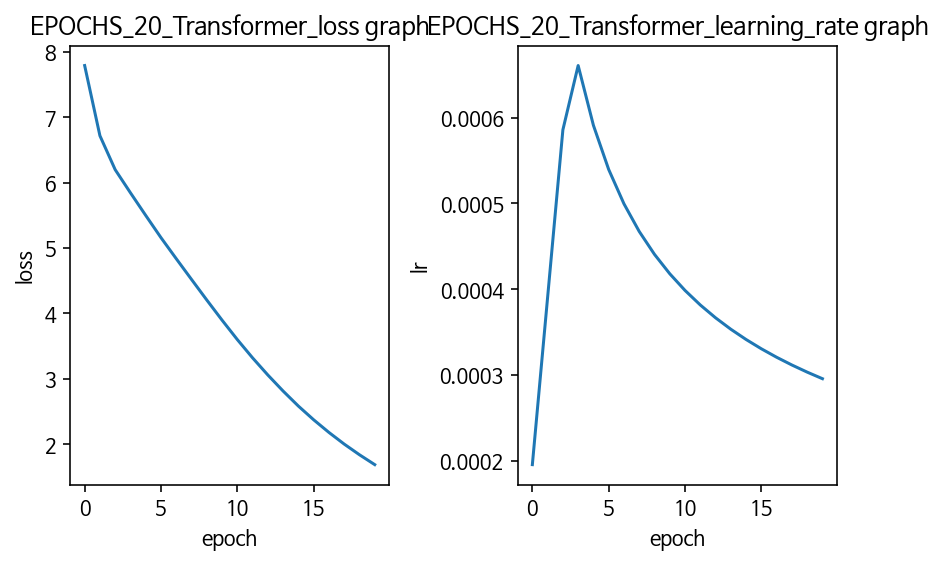

EPOCHS_Best_loss ['20', {'loss': [7.7896, 6.7158, 6.1963, 5.8426, 5.4966, 5.1563, 4.8344, 4.5173, 4.2025, 3.8945, 3.5973, 3.3173, 3.0553, 2.8096, 2.5799, 2.3703, 2.177, 1.9987, 1.8355, 1.6844], 'val_loss': [], 'lr': [0.00019530655, 0.0003906131, 0.00058591965, 0.0006608671, 0.00059109746, 0.0005395957, 0.0004995686, 0.0004673036, 0.00044057803, 0.00041796904, 0.00039851782, 0.0003815518, 0.00036658312, 0.0003532483, 0.0003412703, 0.00033043354, 0.00032056763, 0.00031153572, 0.0003032266, 0.00029554873], 'result': [[0, '오바마는 대통령이다.', 'obama is the president'], [0, '시민들은 도시 속에 산다.', 'the affirmative is the first of the  ⁇ '], [0, '커피는 필요 없다.', 'the time is a .'], [0, '일곱 명의 사망자가 발생했다.', 'the u . s .'], [1, '오바마는 대통령이다.', 'obama is the first time .'], [1, '시민들은 도시 속에 산다.', 'the move is the first time .'], [1, '커피는 필요 없다.', 'the greene s  ⁇ '], [1, '일곱 명의 사망자가 발생했다.', 'the two were also , the country , said .'], [2, '오바마는 대통령이다.', 'obama is a very president .'], [2, '시민들은 도시 속에 산다.', 'the 

In [38]:
# 하이퍼 튜닝_학습
from tqdm import tqdm_notebook 
import tqdm

#Training Parameters
warmup_steps = 4000
BATCH_SIZE = 64
EPOCHS = 20 

n_layers= 2
d_model= 512
n_heads= 8  
d_ff= 2048
src_vocab_size = 25000
tgt_vocab_size = 25000
pos_len = 50  
dropout= 0.3
optimizer = []
shared=True


examples = ["오바마는 대통령이다.", "시민들은 도시 속에 산다.", "커피는 필요 없다.", "일곱 명의 사망자가 발생했다."]

## Hyper param tuning : hparam 한개씩 해서,search space 구성후, loss가 제일 낮은 param을 1차 자동선택후,  번역수준을 눈으로 추가확인  
# hpname list 설정
hp_name_list = ['EPOCHS'] 

# search space 설정: param 설정
dropout_list = [0.1,0.3,0.5]
optimizer_list = [tf.keras.optimizers.RMSprop(learning_rate),tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)]
warmup_steps_list = [2000,4000,6000]
d_model_list = [256,1024]
batchsize_list = [64,128, 256]
epoch_list= [20]

# 금번 Tuning 대상 설정
total_hyperparam_list = [epoch_list]

# 필요 list
hyperparam_list = []
Best_hpname_param_list = []

# 학습 Histoty Dict 설정
history={}

# Hyper param Tuning 실행
for ix, hpname in enumerate(hp_name_list):
    history[hpname]={}
    hyperparam_list = total_hyperparam_list[ix]    
    for i, param in enumerate(hyperparam_list):
        print("i",i, "param",param)
        history[hpname][f'{param}']= {'loss':[], 'val_loss':[], 'lr':[],'result':[]}

        del transformer

        # 트랜스포머 모델설정
        transformer = Transformer(n_layers,
                                  d_model,
                                  n_heads,
                                  d_ff,
                                  src_vocab_size,
                                  tgt_vocab_size,
                                  pos_len,
                                  dropout,
                                  shared=True)

        # 학습율 객체화 
        learning_rate = LearningRateScheduler(d_model = d_model, warmup_steps = warmup_steps)
        optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
        
        # 별도 학습율 계산 함수 정의
        def compute_lr(step,warmup_steps):
            arg1 = step ** -0.5
            arg2 = step * (warmup_steps ** -1.5)
            lr= (d_model ** -0.5) * tf.math.minimum(arg1, arg2)
            lr = lr.numpy()
            return lr
        

        @tf.function()
        def train_step(src, tgt, model, optimizer):
            gold = tgt[:, 1:]

            enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

            # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
            with tf.GradientTape() as tape:
                predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
                loss = loss_function(gold, predictions[:, :-1])

                # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
                # [[YOUR CODE]]
                variables = model.encoder.trainable_variables + model.decoder.trainable_variables 
                gradients = tape.gradient(loss, variables)
                optimizer.apply_gradients(zip(gradients, variables))

            return loss, enc_attns, dec_attns, dec_enc_attns
        

        count_step = 0
        for epoch in range(param):  #EPOCHS):
            total_loss = 0

            idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
            random.shuffle(idx_list)
            t = tqdm.notebook.tqdm(idx_list)  #tqdm_notebook(idx_list)
            
            for (batch, idx) in enumerate(t):
                count_step+= 1
                batch_loss, enc_attns, dec_attns, dec_enc_attns = train_step(enc_train[idx:idx+BATCH_SIZE],
                                            dec_train[idx:idx+BATCH_SIZE],transformer, optimizer)  

                total_loss += batch_loss      #batch_loss: 배치단위인데, 배치내에서, seq_len으로 나눈것,즉,배치내 단어별 평균손실
                batch_loss1 = round(total_loss.numpy() / (batch + 1),4)   # 총누적손실을 누적배치size로 나눈것,즉,배치별 평균
                
                t.set_description_str('Epoch %2d' % (epoch + 1))
                t.set_postfix_str('Loss %.4f' % (batch_loss1))
                
                # step기준 learning_rate
                lr = compute_lr(count_step, warmup_steps)
                
                # step기준 batch 단위 loss 집계 
                #history[hpname][f'{param}']['loss'].append(batch_loss1)
                #history['lr'].append(optimizer.learning_rate)
                #history['lr'].append(optimizer.learning_rate)
                
            print("Epoch",epoch, "Epoch_변화시_학습율적용_step >> count_step",count_step, "lr", lr)    
            
            # epoch기준 loss 및 lr 집계   
            print('epoch_loss', batch_loss1)
            history[hpname][f'{param}']['loss'].append(batch_loss1)
            history[hpname][f'{param}']['lr'].append(lr)
            
            
            for example in examples:
                translate_result = translate(example, transformer, kor_tokenizer, eng_tokenizer, epoch, plot_attention= False) #True)
                history[hpname][f'{param}']['result'].append(translate_result)


        # loss 그래프 
        print("history.keys()",history.keys(), history[hpname].keys() ) 
        print("history[hpname][f'{param}']['loss']", history[hpname][f'{param}']['loss'])
        print("history[hpname][f'{param}']['lr']", history[hpname][f'{param}']['lr'])
        
        fig,ax = plt.subplots(1,2)
        ax[0].plot(range(len(history[hpname][f'{param}']['loss'])),history[hpname][f'{param}']['loss'])
        ax[0].set_title(hpname +'_'+  f'{param}_Transformer_loss graph')
        ax[0].set_xlabel('epoch')
        ax[0].set_ylabel('loss')
        ax[1].plot(range(len(history[hpname][f'{param}']['lr'])),history[hpname][f'{param}']['lr'])
        ax[1].set_title(hpname +'_'+   f'{param}_Transformer_learning_rate graph')
        ax[1].set_xlabel('epoch')
        ax[1].set_ylabel('lr')
        plt.tight_layout()
        plt.show()
            
    # Best_param 선택 
    
    Best_loss =  [[k1,v1] for k1,v1 in history[hpname].items() if v1['loss'][-1] == np.min([v['loss'][-1] for k,v in history[hpname].items()])][0] 
    print(hpname+"_Best_loss", Best_loss,)
   
    # hpname별 Best_param 집계
    Best_hpname_param_list.append([hpname, Best_loss])
    
print("Best_hpname_param_list",len(Best_hpname_param_list),Best_hpname_param_list)
                                   
# 저장
dfhistory = pd.DataFrame(history)
dfhistory.to_pickle(f'/aiffel/aiffel/transformer/data/History_{hpname}')

df = pd.DataFrame(Best_hpname_param_list)  
df.to_pickle(f'/aiffel/aiffel/transformer/data/Best_hpname_param_list_{hpname}')


## 종합요약

#### 번역문 평가 
"오바마는 대통렬이다" 한문장만 맞고, 나머지 두문장 "시민들은 도시 속에 산다","일곱 명의 사망자가 발생했다"는 문맥속에 단어만 일부 들어있는데, "커피는 필요 없다" 문장은 커피란 단어조차 않들어간 엉뚱한 번역문임

```
[0, '오바마는 대통령이다.', 'obama is the president'],
[8, '시민들은 도시 속에 산다.', 'the men are the men in the city of the city .'],
[16, '커피는 필요 없다.
[14, '일곱 명의 사망자가 발생했다.', 'a small number of dead has been killed .'] 
 
```

#### 하이퍼 파람
warmup_steps = 4000   
BATCH_SIZE = 64   
EPOCHS = 20    

n_layers= 2   
d_model= 512   
n_heads= 8    
d_ff= 2048   
src_vocab_size = 25000   
tgt_vocab_size = 25000   
pos_len = 50     
dropout= 0.3   
optimizer = tf.keras.optimizers.Adam()   
shared=True   




## 회고

본 프로젝트는 트랜스포머모델을 활용하여, 한글을 영어로 번역하는 프로젝트입니다.

한글 및 영어 데이터를 다운로드 받아서, 번역쌍(pair)을 흐트르지 않고서 중복데이터를 제거하기위해, zip 과 set을 사용하여,
중복을 제거하였고(결측치제거 병행), 데이터는 원래 94123 쌍에서, 78968쌍으로 약 15%가 줄었습니다. 

남은 문장들을 대상으로  소문자변환, 숫자및한글및영어및 특수문자, 공백처리등등의 데이터정제 및 target문자 'BOS','EOS'처리를 해주는
preprocess함수를 정의하였고, SentencePiece기법을 사용하여, 한글과 영어를 병행하여, train을 시켜서, 단어토큰화및 정수인덱스토큰화를 할수 있는
generate_tokenizer함수를 만들어서, kor_tokenizer와 eng_tokenizer를 완성하였습니다.          
여기에서, 별도로 'BOS', 'EOS' 코딩않해도 영어문장 앞뒤로 붙게해주는 옵션 tokenizer.set_encode_extra_options("bos:eos")
도 배웠습니다.  preprocess함수에서의 <BOS>,<EOS>처리코드를 삭제해도 되지만, 나중 참조를 위해 메모해두고 유지했습니다.   

SRC_VOCAB_SIZE 와 TGT_VOCAB_SIZE는 25,000로 설정했고,SentencePiece의 EncodeAsPieces,EncodeAsIds를 사용하여, 
사용하기 편리한 단어사전 word_index,index_word을 만들었습니다

여기서, 한글,영어 공히 문장의 최대길이가 50이하가 되도록 maxlen을 50으로 잡고 초과되는 문장을 제거하고서, 
tf.keras.preprocessing.sequence.pad_sequences로 padding처리하였는데, 최종 학습에 들어가는 문장은 78968쌍에서,
71288쌍으로 축소되었고 이문장들은 모두 사용할 예정입니다.

transfor 모델설계는 여태까지 배운 다른 어떤 딥러닝모델보다, 모델내의 중여한 구성품이 많습니다.   
positional_encoding함수,MultiHeadAttention함수,PoswiseFeedForwardNet함수,EncoderLayer함수,DecoderLayer함수,
Encoder함수,Decoder함수,앞서의 layer들을 조합할 Transformer 모델함수를 내부의 작동원리를 코드를 통해 하나하나 익혀가면서,
만들었습니다.

그리고, 마스크를 만들 3개의 함수 generate_padding_mask, generate_causality_mask, generate_masks함수를 만들었는데,
이 함스들로 enc_mask, dec_enc_mask, dec_mask 3종류의 마스크를 만들어서, 인코더의 MultiHeadAttention,
디코더의 masked_MultiHeadAttention, dec_enc_MultiHeadAttention내의 scaled_dot_qk에 적용됩니다.
(디코더에 적용되는 마스크들은 tf.maximum에 의해서, padding과 Not lookahead를 동시에 할수있게 처리되었습니다.
 
train step진행에따라, 학습율이 증가했다가 4000step이후 감소되는 LearningRateScheduler함수, optimize설정및 
labeldata의 padding을 처리해줄 마스크를 적용해주는 custom loss function을 만들었습니다. 

미분및 역전파등 핵심적 학습을 진행시킬 train step함수, 시각화 및 평가함수를 하나 하나 내부의 코드들의 작동순서및 원리들를
파악해가며 만들었습니다.
 
최종적으로 학습 epoch를 진행시킬 for loop 코드를 만들어서, transformer가 train step함수를 통해서,batch size단위별로
학습이 진해되도록 하였고, 학습로그기록을 위해, history dict를 만들어서, epoch별로 학습loss 및 변화되는 learning_rate가
기록되도록 하였습니다. ( learning_rate 는 학습율 계산하는 함수를 산정공식 그대로 적용하여 만들어서, epoch마다 기록및 프린트함)
 
Hyper param Tuning을 위해 KerasTuner를 LMS에 인스톨하여 사용해 보았는데, dependency 문제가 있는지,작동하지를 않아서 사용을 못하고,
학습 loop 상위에 Tuning for loop를 씌워서, dropout rate, warmup_steps, optimizer, batch_size,epoch등을 해보았는데,
LMS교재상의 지정된 Hyper param과 거의 같게 나와서, 시간관계상 나머지 Hyper param은 LMS 그대로 사용하였습니다.   

epock별로 번역결과를 출력해서, 번역결과의 개선여부를 살펴보았는데, 눈에띄게 잘된 번역은 잘 않보이고, 맞는 단어가 한두개이상씩
들어가있는 수준이었습니다. 제출후 시간을 갖고서, layer를 2개로 제한된데서, 4개이상으로 늘려서, 
epoch를 충분히 300 회이상 시켜 보아야 제대로 된 번역이 나올것 같다는 생각입니다.
 
지금 세계적으로 열풍이 부는 chatGPT도 동일한(내부에 개선된 부품코드가 있을 수 있겠으나) 트랜스포머로 만들었으니,
모델 내부의 개선점도 찾아보고, 아이디어들을 발굴접목하며,지속적으로 모델을 개선해서, 현실세계에서, 
다양한 문제에 적용해볼 생각입니다.   
 


In [ ]:
from keras.models import load_model
from keras.utils.vis_utils import model_to_dot

save_path  = '/aiffel/aiffel/transformer/model'

#encoder.save(save_path + '/s2s_encoder_model.h5')
#decoder.save(save_path + '/s2s_decoder_model.h5')

#encoder = load_model('s2s_encoder_model.h5')
#decoder = load_model('s2s_decoder_model.h5')

#model_to_dot(encoder, show_shapes=True)
#model_to_dot(decoder, show_shapes=True)

#transformer.save(save_path)  ??????????????